# A Parametric Study of Batch Size
- In this project we will look at how batch size affects model accuracy and the speed of learning.
- The batch size will be parametrically varied to study the model behavior.
- Other parameters such as epochs and learning rate will be held constant.

In [58]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# importing iris dataset
import seaborn as sns
iris_dataset = sns.load_dataset('iris')

## Data Processing

In [59]:
# converting from pandas dataframe to pytorch tensor
torched_iris_dataset= torch.tensor(iris_dataset[iris_dataset.columns[0:4]].values).float() # only use first 4 columns, because last column is outcome variable or datatype.

# numeric transformation - transforming species name to a number (0-2)
iris_labels = torch.zeros(len(torched_iris_dataset), dtype=torch.long) # species 'setosa' will remain 0.
iris_labels[iris_dataset.species=='versicolor'] = 1
iris_labels[iris_dataset.species=='virginica'] = 2

In [60]:
# splitting iris dataset into training and testing
train_data, test_data, train_labels, test_labels = train_test_split(torched_iris_dataset, iris_labels, train_size= 0.8)

# converting to torch tensors, grouping data and labels
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

In [61]:
# creates data loaders with specified 2^N batch size
def create_data_loaders(training_dataset, testing_dataset, batch_size):    
    
    train_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(testing_dataset, shuffle=True, batch_size= test_data.tensors[0].shape[0])
    return train_loader, test_loader

## Model Creation and Training

In [62]:
def create_ANN_model(learning_rate):
    
    # model architecture
    ANN_model = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )

    # loss function
    loss_function = nn.CrossEntropyLoss()

    # optimizer, this is where L2 penalty is applied
    optimizer = torch.optim.SGD(ANN_model.parameters(), lr=learning_rate)

    return ANN_model, loss_function, optimizer

In [63]:
def batch_train_model(number_of_epochs, ANN_iris, loss_function, optimizer, train_loader, test_loader):
    
    training_accuracy_ary = []
    testing_accuracy_ary = []
    losses_ary = []

    # loop over epochs
    for epoch_IDX in range(number_of_epochs):

        batch_accuracy = []
        batch_loss = []
        
        for batch, labels in train_loader:
        # forward pass and calculate loss
            y_hat = ANN_iris(batch)
            loss = loss_function(y_hat, labels)

            # backpropagation (learning)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy for current batch
            batch_accuracy.append(100*torch.mean((torch.argmax(y_hat, axis=1) == labels).float()).item())

            # batch losses
            batch_loss.append(loss.item())

        # calculate overall training accuracy and loss
        training_accuracy_ary.append(np.mean(batch_accuracy))
        losses_ary.append(np.mean(batch_loss))

        # Cross Validation of Model
        X_data, y_labels = next(iter(test_loader)) # there is only one batch, so there's no need for a for loop
        
        with torch.no_grad(): # disables gradient-related computations, appropriate when testing model
            predicted_testing_labels = torch.argmax(ANN_iris(X_data),axis=1)

        # calculate testing accuracy
        testing_accuracy_ary.append(100*torch.mean((predicted_testing_labels == y_labels).float()).item())

    return training_accuracy_ary, testing_accuracy_ary, losses_ary

### Short Sanity Check for Model Creation and Training

In [64]:
# model params
learning_rate = 0.01
num_epochs = 500
batch = 2

train_ldr, test_ldr = create_data_loaders(train_data, test_data, batch_size=batch)

# creating and training model
ANN_iris, loss_function, optimizer = create_ANN_model(learning_rate)
training_acc, test_acc, losses = batch_train_model(num_epochs, ANN_iris, loss_function, optimizer, train_ldr, test_ldr)

# Parametric Experiment!

In [65]:
# experiment params
learning_rate = 0.01
num_epochs = 500
batch_sizes = 2**np.arange(1,7)

# arrays to store results
training_accuracy = np.zeros((num_epochs, len(batch_sizes)))
test_accuracy = np.zeros((num_epochs, len(batch_sizes)))
losses_array = np.zeros((num_epochs,  len(batch_sizes)))

# loop over batch sizes
for batch_IDX in range(len(batch_sizes)):
    
    # create data loaders with specified batch size
    train_loader, test_loader = create_data_loaders(train_data, test_data, int(batch_sizes[batch_IDX]))

    ANN_iris, loss_function, optimizer = create_ANN_model(learning_rate)
    training_acc, test_acc, losses = batch_train_model(num_epochs, ANN_iris, loss_function, optimizer, train_loader, test_loader)

    training_accuracy[:, batch_IDX] = training_acc
    test_accuracy[:, batch_IDX] = test_acc
    losses_array[:, batch_IDX] = losses

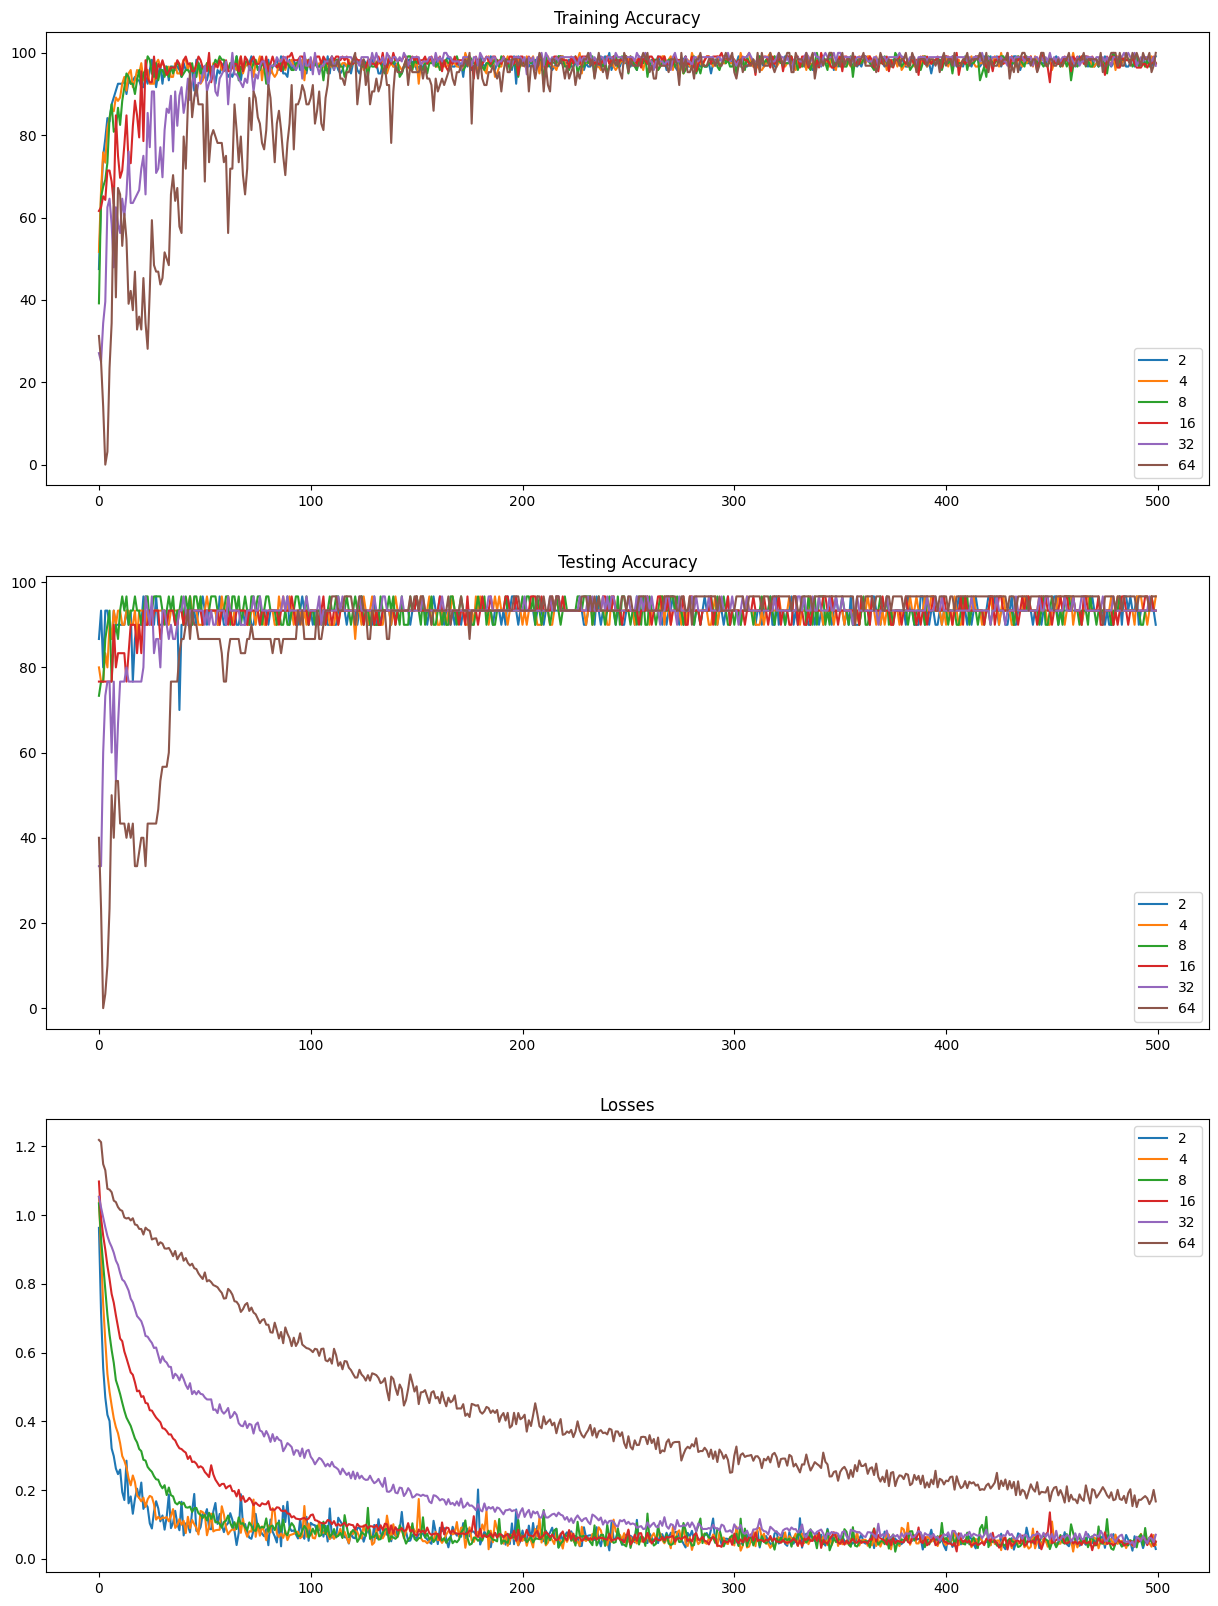

In [66]:
# plot results
fig, ax = plt.subplots(3, 1, figsize = (15,20))

ax[0].plot(training_accuracy)
ax[0].set_title('Training Accuracy')
ax[0].legend(batch_sizes)

ax[1].plot(test_accuracy)
ax[1].set_title('Testing Accuracy')
ax[1].legend(batch_sizes)

ax[2].plot(losses_array)
ax[2].set_title('Losses')
ax[2].legend(batch_sizes)

plt.show()

## Important Observations
- Depending on the model and types of data you have, the model will do better with either larger or smaller batch sizes.
- Performance also depends on learning rate, number of epochs, and if the model can get through all of the data in the batch at each epoch.
- This model is simple and the data is homogenous. The model can learn a surprising amount on smaller amounts of data. 
    - It generally will perform better with smaller batch sizes.
    - This can be seen as a general trend in the above graphs.
    - The model trained with larger batch sizes at `0.01` learning rate had higher overall losses, even towards the end of training.